# Model Training
We aim to use the following models:

1. Baseline model: zerorate classifier
2. Feed Forward Neural Nets with and without embeddings
3. Pre-trained Transformers: TabNet by Google
4. Voting classifiers


In [1]:
# Standard
import pandas as pd
import numpy as np 

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# tf and keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

# Pytorch
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# xgboost 
import xgboost as xgb

# shap
import shap

# classifier for zero rate regression
from sklearn.dummy import DummyClassifier

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import Image, display

import warnings
warnings.filterwarnings("ignore")

/Users/lucymherr/miniforge3/envs/w207_final/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [2]:
# Helper function
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

# Load and prepare data

In [3]:
# Load train file
train_file = 'split_train_clean.csv' 
train = pd.read_csv(train_file)

# Load test file
test_file = 'split_test_clean.csv'
test = pd.read_csv(test_file)

print(f'Shape of train file: {train.shape}')
print(f'Shape of test file: {test.shape}')

Shape of train file: (11994, 92)
Shape of test file: (2999, 92)


# Pre processing for NN

In [4]:
# Print statements
print(f'Shape of X_train before dropping: {train.shape}')

# Dropping unsued columns 
drop_cols = ['Unnamed: 0.1', 'Unnamed: 0', 'Name', 
             'PetID', 'label_descriptions', 'label_scores',
             'languages','StateName', 'has_Photo', 'has_descriptoin']

train.drop(columns = drop_cols, axis = 1, inplace=True)
test.drop(columns = drop_cols, axis = 1, inplace=True)

# Print statements
print(train.columns)
print(f'Shape of X_train after dropping: {train.shape}')
print(f'Shape of X_test: {test.shape}')

Shape of X_train before dropping: (11994, 92)
Index(['Type', 'Age', 'Breed1_0', 'Breed1_1', 'Breed1_2', 'Breed1_3',
       'Breed1_4', 'Breed1_5', 'Breed1_6', 'Breed1_7', 'Breed2_0', 'Breed2_1',
       'Breed2_2', 'Breed2_3', 'Breed2_4', 'Breed2_5', 'Breed2_6',
       'MaturitySize', 'FurLength', 'Vaccinated_1', 'Vaccinated_2',
       'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3',
       'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health', 'Quantity',
       'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3', 'VideoAmt',
       'Description', 'PhotoAmt', 'AdoptionSpeed', 'vertex_xs', 'vertex_ys',
       'bounding_confidences', 'bounding_importance_fracs', 'dominant_blues',
       'dominant_greens', 'dominant_reds', 'dominant_pixel_fracs',
       'dominant_scores', 'doc_scores', 'doc_magnitudes', 'state_population',
       'median_state_income', 'Invalid_name', 'IsTopRescuer', 'RescuerCount',
       'Fee_binary', 'Fee_bin_1', 'Fee_bin_2', 'Fee_bin_3', 'Fee_bin_4',

In [5]:
# Input data
print(f' Number of missing data points pre: {sum(train.isna().sum())}')

# Drop NAs
train = train.dropna()
test = test.dropna()

print(f' Number of missing data points post: {sum(train.isna().sum())}')

 Number of missing data points pre: 10
 Number of missing data points post: 0


In [6]:
# Group 0 & 1 and relabel target variable in train and test
relabel_dict = { 0:0, 1:0, 2:1, 3:2, 4:3 }
train['AdoptionSpeed'] = train['AdoptionSpeed'].map(relabel_dict)
test['AdoptionSpeed'] = test['AdoptionSpeed'].map(relabel_dict)

# Value counts of re-labeled AdoptionSpeed
adoption_speed_counts = train['AdoptionSpeed'].value_counts()
adoption_speed_counts

AdoptionSpeed
3    3361
1    3227
0    2779
2    2617
Name: count, dtype: int64

In [7]:
# Find minimum class count 
group_size = adoption_speed_counts.min()

# Downsample so all 4 categories have equal reviews in train
temp_0 = train[train.AdoptionSpeed.eq(0)].sample(
    n=group_size,
    replace=False, 
    random_state=42)

temp_1 = train[train.AdoptionSpeed.eq(1)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_2 = train[train.AdoptionSpeed.eq(2)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_3 = train[train.AdoptionSpeed.eq(3)].sample(
    n=group_size,
    replace=False,
    random_state=42)

train_bal = pd.concat(
    [temp_0, temp_1, temp_2, temp_3],
    axis=0)

# shuffle df_balanced
train_bal.sample(frac=1, random_state=42) # frac=1 retains all the data
train_bal.reset_index(drop=True, inplace=True) # reset index

print('After downsampling, our data contains', train_bal.shape[0], 'pets and', train_bal.shape[1], 'columns')

After downsampling, our data contains 10468 pets and 82 columns


In [8]:
train_bal.head()

,Type,Age,Breed1_0,Breed1_1,Breed1_2,Breed1_3,Breed1_4,Breed1_5,Breed1_6,Breed1_7,...,isFemale,Black,Brown,Golden,Yellow,Cream,Gray,White,ColorCount,isGeneric_Breed
0,1,24,0,0,0,0,0,1,1,1,...,0,1,0,0,0,0,0,0,1,0
1,1,2,0,0,0,0,0,0,0,1,...,1,1,1,0,0,0,0,0,2,1
2,1,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,0,0,0,3,1
3,0,2,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,1,2,1
4,1,36,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,1


In [9]:
# Train data
y_train_raw = train_bal['AdoptionSpeed']
X_train_raw = train_bal.drop('AdoptionSpeed', axis=1)

# Test data
y_test = test['AdoptionSpeed']
X_test = test.drop('AdoptionSpeed', axis=1)

# Print statement
print(f'Shape of X_train: {X_train_raw.shape}')
print(f'Shape of y_train: {y_train_raw.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (10468, 81)
Shape of y_train: (10468,)
Shape of X_test: (2996, 81)
Shape of y_test: (2996,)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw, test_size=0.2, 
                                                  stratify = y_train_raw, random_state=42)

# Print shape statement
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of X_train: (8374, 81)
Shape of y_train: (8374,)
Shape of X_val: (2094, 81)
Shape of y_val: (2094,)


In [11]:
# Check distribution
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 524, 1: 523, 2: 524, 3: 523}

In [12]:
# Change data types
y_train = np.array(y_train)
y_val = np.array(y_val)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(8374, 81)
(8374,)
(2094, 81)
(2094,)
(2996, 81)
(2996,)


# Baseline Model: Zero Rate Regression

Our baseline model uses zero rate regression based on the most frequent outcome class (AdoptionSpeed = 3). 

In [14]:
# Baseline model 1: zero-rate classifier 

# Train data for ZRR (pre-downsampling to reflect original Adoption counts)
y_train_zrr = train['AdoptionSpeed']
x_train_zrr = train.drop('AdoptionSpeed', axis=1)

# Most frequent outcome class
class_counts = y_train_zrr.value_counts().reset_index() #()) #/train.shape[0]
most_freq_class = class_counts.iloc[0,0]
most_freq_prct = round((np.max(class_counts["AdoptionSpeed"])/sum(class_counts["AdoptionSpeed"]))*100, 2)
print(f"In the original train set, the most frequent AdoptionSpeed class is {most_freq_class}, with {most_freq_prct}% of the observations.\n")

# Predict value of most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train_zrr, y_train_zrr)
dummy_clf.predict(x_train_zrr)

# Return the mean accuracy on original train data and labels
zrr_score1 = dummy_clf.score(x_train_zrr, y_train_zrr)
print(f"The mean accuracy score on the original train data is {zrr_score1}\n")

# Return the mean accuracy on validation data and labels
zrr_score2 = dummy_clf.score(X_val, y_val)
print(f"The mean accuracy score on validation data is {zrr_score2}\n")

# Return the mean accuracy on test data and labels
zrr_score3 = dummy_clf.score(X_test, y_test)
print(f"The mean accuracy score on test set is {zrr_score3}\n")

In the original train set, the most frequent AdoptionSpeed class is 3, with 50.0% of the observations.

The mean accuracy score on the original train data is 0.2804572763684913

The mean accuracy score on validation data is 0.24976122254059216

The mean accuracy score on test set is 0.277369826435247



In [15]:
# ZRR for F1 score on validation set
print(f" F1 Score in Validation set: {f1_score(y_val, np.full(y_val.shape,0), average='weighted')}")
         
# ZRR for F1 score on test set
print(f" F1 Score in Test set: {f1_score(y_test, np.full(y_test.shape,3), average='weighted')}")

 F1 Score in Validation set: 0.10017197814265064
 F1 Score in Test set: 0.12045692488512687


# Neural Networks

In [16]:
# Apply StandadScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train.drop('Description',axis = 1))
X_val_std = scaler.fit_transform(X_val.drop('Description',axis = 1))
X_test_std = scaler.fit_transform(X_test.drop('Description',axis = 1))

In [17]:
# Print shape statement
print(f'Shape of X_train: {X_train_std.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_val: {X_val_std.shape}')
print(f'Shape of y_val: {y_val.shape}')
print(f'Shape of X_test: {X_test_std.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (8374, 80)
Shape of y_train: (8374,)
Shape of X_val: (2094, 80)
Shape of y_val: (2094,)
Shape of X_test: (2996, 80)
Shape of y_test: (2996,)


In [18]:
# Check one sample
X_train_std[0]

array([ 9.15872815e-01, -3.66662550e-01, -8.91299625e-02, -1.84614435e-01,
        4.03753054e+00, -4.16122274e-01, -3.68463881e-01,  1.94835966e+00,
        1.20982056e+00, -1.11635328e+00, -1.09378911e-01, -1.78651069e-01,
       -2.10094386e-01, -2.39979792e-01, -3.06006220e-01, -5.26965855e-01,
        4.72436268e-01,  2.68805803e-01, -7.84825115e-01,  1.04121153e+00,
       -3.79458919e-01, -8.06861349e-01,  1.47866615e+00, -1.14152543e+00,
       -3.69925619e-01,  6.91708358e-01, -3.69299528e-01, -5.05628835e-01,
       -1.84191538e-01, -3.96512803e-01, -3.02369219e-01, -1.46521844e-01,
       -6.72724716e-01, -3.46796134e-01,  6.71601329e-01, -1.69587375e-01,
       -2.69639990e-01, -1.80793917e-01,  8.48322327e-01,  1.36330736e-01,
        1.39306015e-01,  1.18606314e+00,  1.13017152e+00,  1.04649488e+00,
        1.23473365e+00, -1.42327629e-01, -2.55870560e-01,  1.66133719e+00,
        8.26092071e-01,  1.20794958e-01, -5.47084805e-01, -4.67512676e-01,
       -4.35354332e-01, -

## Basic FFNN (no text embedding, only numeric featuers)

In [19]:
def build_ffnn_basic(num_features, learning_rate=0.001):

    # Set-up
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    # Initialize model
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
        
    # First Dense layer
    model.add(tf.keras.layers.Dense(units=32,activation='relu', name='fc_1'))

    # Second Dense
    model.add(tf.keras.layers.Dense(units=16,activation='relu', name='fc_2'))
    
    # create output layer
    model.add(tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax', 
          name='Output'))
    
    # Compile model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model

# Build model
ffnn1 = build_ffnn_basic(num_features = X_train_std.shape[1], learning_rate=0.01)
ffnn1.summary()

Metal device set to: Apple M1 Pro


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 32)                2592      
                                                                 
 fc_2 (Dense)                (None, 16)                528       
                                                                 
 Output (Dense)              (None, 4)                 64        
                                                                 
Total params: 3,184
Trainable params: 3,184
Non-trainable params: 0
_________________________________________________________________


In [20]:
# EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Fit basic model
history = ffnn1.fit(
    x=X_train_std,
    y=y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val_std, y_val),
    verbose=0,
    callbacks=[es])

2023-08-06 14:50:52.664958: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [21]:
print(f"Average train accuracy last 10 epochs: {sum(history.history['accuracy'][-10:]) / 10}")
print(f"Average val_accuracy last 10 epochs: {sum(history.history['val_accuracy'][-10:]) / 10}")

Average train accuracy last 10 epochs: 0.4325412005186081
Average val_accuracy last 10 epochs: 0.3827125132083893


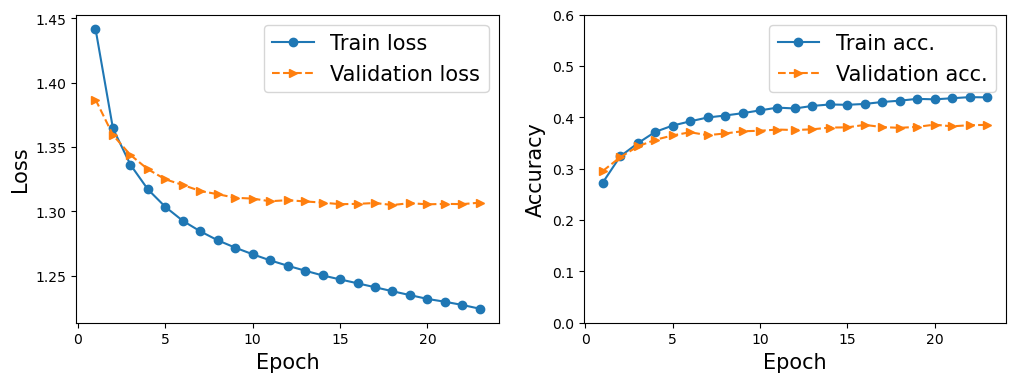

In [22]:
# Plot 
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '-->', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '-->', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

66/66 [==============================] - 0s 2ms/step


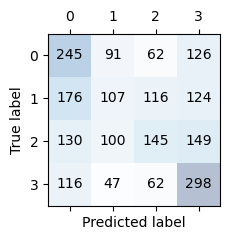

In [23]:
# Confusion matrix on validation set
y_val_pred_ffnn1 = np.argmax(ffnn1.predict(X_val_std),axis=1)
confusion_matrix_basic = confusion_matrix(y_val, y_val_pred_ffnn1)
confusion_matrix_plot(confusion_matrix_basic)

In [24]:
# Classification for ffnn1 report on val set
print(classification_report(y_val, y_val_pred_ffnn1))

              precision    recall  f1-score   support

           0       0.37      0.47      0.41       524
           1       0.31      0.20      0.25       523
           2       0.38      0.28      0.32       524
           3       0.43      0.57      0.49       523

    accuracy                           0.38      2094
   macro avg       0.37      0.38      0.37      2094
weighted avg       0.37      0.38      0.37      2094



In [25]:
# ffnn1 on test set
ffnn1 = build_ffnn_basic(num_features = X_train_std.shape[1], learning_rate=0.01)
test_loss, test_accuracy = ffnn1.evaluate(X_test_std, y_test, verbose=1)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_accuracy))

94/94 [==============================] - 1s 5ms/step - loss: 1.8307 - accuracy: 0.2333
Test Loss: 1.8307305574417114
Test Accuracy: 0.23331108689308167


In [26]:
# Classification report for ffnn1 on test set
y_test_pred_ffnn1 = np.argmax(ffnn1.predict(X_test_std),axis=1)
print(classification_report(y_test, y_test_pred_ffnn1))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.23      0.81      0.36       719
           1       0.25      0.08      0.13       805
           2       0.18      0.00      0.01       641
           3       0.24      0.06      0.09       831

    accuracy                           0.23      2996
   macro avg       0.23      0.24      0.15      2996
weighted avg       0.23      0.23      0.15      2996



In [27]:
# Print cohen kappa score on test set
cohen_kappa_score(y_test, y_test_pred_ffnn1)

-0.015487717457097316

## Fine-tuned Basic FFNN (no text embedding, only numeric featuers)

In [28]:
def build_ffnn_ad(num_features, learning_rate):

    # Set-up
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    # Initialize model
    model = tf.keras.Sequential()    
    
    # Input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    # First Dense and dropout layer 
    model.add(tf.keras.layers.Dense(units=64, activation='relu',  
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=0),
                                    name='fc_1'))
    
    model.add(tf.keras.layers.Dropout(0.25))    
    
    # Second Dense and dropout layer 
    model.add(tf.keras.layers.Dense(units=32, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=0),
                                    name='fc_2'))

    model.add(tf.keras.layers.Dropout(0.25))
    
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax',
          name='Output'))
    
    # Optimizer model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, weight_decay=1e-2,
                                        momentum=0.3, nesterov=True)
    #opt = tfa.optimizers.Lookahead(optimizer)
    
    # Compile model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model


# Build model
ffnn2 = build_ffnn_ad(num_features = X_train_std.shape[1], learning_rate=0.0025)
ffnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_1 (Dense)                (None, 64)                5184      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 fc_2 (Dense)                (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 Output (Dense)              (None, 4)                 128       
                                                                 
Total params: 7,392
Trainable params: 7,392
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit advanced model
history_ad = ffnn2.fit(
    x=X_train_std,
    y=y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_std, y_val),
    verbose=0,
    callbacks=[es])

In [30]:
print(f"Average train accuracy last 10 epochs: {sum(history_ad.history['accuracy'][-10:]) / 10}")
print(f"Average val_accuracy last 10 epochs: {sum(history_ad.history['val_accuracy'][-10:]) / 10}")

Average train accuracy last 10 epochs: 0.4328994482755661
Average val_accuracy last 10 epochs: 0.38729703426361084


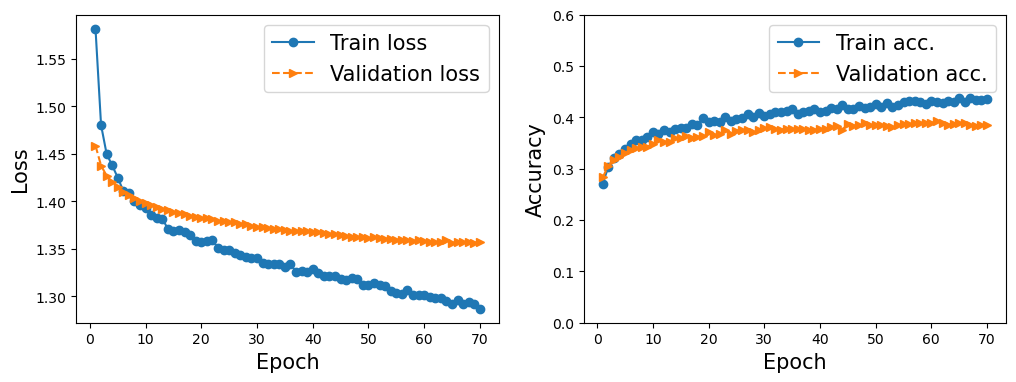

In [31]:
# Plot curves
hist_ad = history_ad.history
x_arr = np.arange(len(hist_ad['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_ad['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_ad['val_loss'], '-->', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_ad['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_ad['val_accuracy'], '-->', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

66/66 [==============================] - 0s 2ms/step


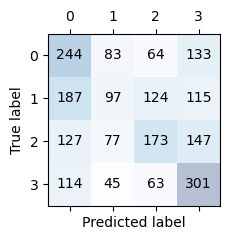

In [32]:
# Confusion matrix for ffnn2 on val set
y_val_pred_ffnn2 = np.argmax(ffnn2.predict(X_val_std),axis=1)
confusion_matrix_ad = confusion_matrix(y_val, y_val_pred_ffnn2)
confusion_matrix_plot(confusion_matrix_ad)

In [33]:
# Classification report for ffnn2 on val set
print(classification_report(y_val, y_val_pred_ffnn2))

              precision    recall  f1-score   support

           0       0.36      0.47      0.41       524
           1       0.32      0.19      0.24       523
           2       0.41      0.33      0.36       524
           3       0.43      0.58      0.49       523

    accuracy                           0.39      2094
   macro avg       0.38      0.39      0.38      2094
weighted avg       0.38      0.39      0.38      2094



In [34]:
# use the model on test set (for ffnn2)
ffnn2 = build_ffnn_ad(num_features = X_train_std.shape[1], learning_rate=0.0025)
test_loss2, test_accuracy2 = ffnn2.evaluate(X_test_std, y_test, verbose=1)
print('Test Loss: {}'.format(test_loss2))
print('Test Accuracy: {}'.format(test_accuracy2))

94/94 [==============================] - 1s 5ms/step - loss: 1.6599 - accuracy: 0.2560
Test Loss: 1.6598929166793823
Test Accuracy: 0.2560080289840698


In [35]:
# Classification report for ffnn2 on test set
y_test_pred_ffnn2 = np.argmax(ffnn2.predict(X_test_std),axis=1)
print(classification_report(y_test, y_test_pred_ffnn2))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.23      0.17      0.19       719
           1       0.26      0.67      0.37       805
           2       0.10      0.01      0.02       641
           3       0.35      0.12      0.18       831

    accuracy                           0.26      2996
   macro avg       0.23      0.24      0.19      2996
weighted avg       0.24      0.26      0.20      2996



In [36]:
# Print cohen kappa score on test set for ffnn2
cohen_kappa_score(y_test, y_test_pred_ffnn2)

-0.0089669716293177

## FFNN using Description alone with embedding layer 

In [37]:
X_train_embed = X_train['Description']
X_val_embed = X_val['Description']
X_test_embed = X_test['Description']

In [38]:
vocab_size = 1000
max_sequence_length = 100
embedding_dim = 8

#initialize TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length)

#fit it on the training data
vectorize_layer.adapt(X_train_embed.to_numpy())


#vectorize the data
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)


X_train_embed = vectorize_text(X_train_embed)
X_val_embed = vectorize_text(X_val_embed)

#build the model
ffnn3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes in 'AdoptionSpeed'
])

ffnn3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              metrics=['accuracy'])

# Train the model
history3 = ffnn3.fit(
    X_train_embed,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_embed, y_val),
    verbose=0, 
    callbacks=[es])

In [39]:
ffnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            8000      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
Total params: 8,108
Trainable params: 8,108
Non-trainable params: 0
_________________________________________________________________


In [40]:
print(f"Average train accuracy last 5 epochs: {sum(history3.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history3.history['val_accuracy'][-5:]) / 5}")

Average train accuracy last 5 epochs: 0.4202770471572876
Average val_accuracy last 5 epochs: 0.33304679989814756


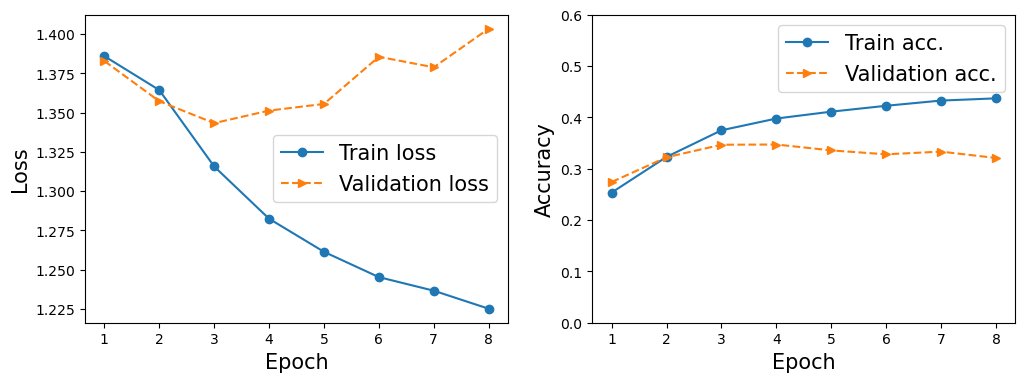

In [41]:
# Plot ffnn3
hist3 = history3.history
x_arr = np.arange(len(hist3['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist3['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist3['val_loss'], '-->', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist3['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist3['val_accuracy'], '-->', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

In [42]:
# Classification report for ffnn3 on val set
y_val_pred_ffnn3 = np.argmax(ffnn3.predict(X_val_embed),axis=1)
print(classification_report(y_val, y_val_pred_ffnn3))

66/66 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.35      0.40      0.37       524
           1       0.38      0.02      0.05       523
           2       0.40      0.28      0.33       524
           3       0.33      0.68      0.44       523

    accuracy                           0.35      2094
   macro avg       0.36      0.35      0.30      2094
weighted avg       0.36      0.35      0.30      2094



In [43]:
# Evaluate ffnn3 model on test set
X_test_embed = test['Description']
X_test_embed = vectorize_text(X_test_embed)

ffnn3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              metrics=['accuracy'])

test_loss3, test_accuracy3 = ffnn3.evaluate(X_test_embed, y_test, verbose=1)
print('Test Loss: {}'.format(test_loss3))
print('Test Accuracy: {}'.format(test_accuracy3))

94/94 [==============================] - 1s 5ms/step - loss: 1.3297 - accuracy: 0.3381
Test Loss: 1.329703450202942
Test Accuracy: 0.3381175100803375


In [44]:
# Classification report for ffnn3 on test set
y_test_pred_ffnn3 = np.argmax(ffnn3.predict(X_test_embed),axis=1)
print(classification_report(y_test, y_test_pred_ffnn3))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.31      0.38      0.34       719
           1       0.38      0.02      0.04       805
           2       0.32      0.25      0.28       641
           3       0.36      0.68      0.47       831

    accuracy                           0.34      2996
   macro avg       0.34      0.33      0.28      2996
weighted avg       0.34      0.34      0.28      2996



## Full FFNN (embedding + numeric)

In [45]:
# Embedding pre processing
vocab_size = 1000
max_sequence_length = 100
embedding_dim = 8

print('vocab_size: ',vocab_size)
print('max_sequence_length: ',max_sequence_length)
print('embedding_dim: ',embedding_dim)

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train['Description']) 

X_train_description = pad_sequences(tokenizer.texts_to_sequences(X_train['Description']), maxlen=max_sequence_length)
X_val_description = pad_sequences(tokenizer.texts_to_sequences(X_val['Description']), maxlen=max_sequence_length)
X_test_description = pad_sequences(tokenizer.texts_to_sequences(X_test['Description']), maxlen=max_sequence_length)

vocab_size:  1000
max_sequence_length:  100
embedding_dim:  8


In [46]:
# Check shapes
print(X_train_description.shape)
print(X_train_std.shape)
print(y_train.shape)

print(X_val_description.shape)
print(X_val_std.shape)
print(y_val.shape)

print(X_test_description.shape)
print(X_test_std.shape)
print(y_test.shape)

(8374, 100)
(8374, 80)
(8374,)
(2094, 100)
(2094, 80)
(2094,)
(2996, 100)
(2996, 80)
(2996,)


In [47]:
def build_ffnn_with_embedding(num_features, vocab_size, embedding_dim, maxlen, learning_rate=0.001):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    np.random.seed(0)
  
    input_text = tf.keras.Input(shape=(max_sequence_length,), name='Input_Text')
    input_num = tf.keras.Input(shape=(num_features,), name='Input_Numeric')
    
    #embedding layer for text
    x_text = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(input_text)
    x_text = tf.keras.layers.Flatten()(x_text)
    
    #concatenate all inputs
    x = tf.keras.layers.Concatenate()([x_text, input_num])

    x = tf.keras.layers.Dense(units=16, activation='relu',  
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=0),
                                    name='fc_1')(x)
    x = tf.keras.layers.Dropout(0.25)(x) #regularization

    x = tf.keras.layers.Dense(units=8, activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=0),
                                    name='fc_2')(x)
    x = tf.keras.layers.Dropout(0.25)(x) #regularization

    output = tf.keras.layers.Dense(
          units=4,  
          use_bias=False,
          activation='softmax',
          name='Output')(x)
    
    model = tf.keras.Model(inputs=[input_text, input_num], outputs=output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model

ffnn4 = build_ffnn_with_embedding(num_features=X_train_std.shape[1], learning_rate=0.0025,
                                  vocab_size=vocab_size, embedding_dim=embedding_dim,
                                  maxlen=max_sequence_length)
ffnn4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Text (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 8)       8000        ['Input_Text[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 800)          0           ['embedding[0][0]']              
                                                                                                  
 Input_Numeric (InputLayer)     [(None, 80)]         0           []                               
                                                                                              

In [48]:
# Fit advanced model
history4 = ffnn4.fit(
    x=[X_train_description, X_train_std],
    y=y_train,
    epochs=50,
    batch_size=16,
    validation_data=([X_val_description, X_val_std], y_val), 
    verbose=0,
    callbacks=[es])

In [49]:
print(f"Average train accuracy last 5 epochs: {sum(history4.history['accuracy'][-5:]) / 5}")
print(f"Average val_accuracy last 5 epochs: {sum(history4.history['val_accuracy'][-5:]) / 5}")

Average train accuracy last 5 epochs: 0.4801528573036194
Average val_accuracy last 5 epochs: 0.37669532299041747


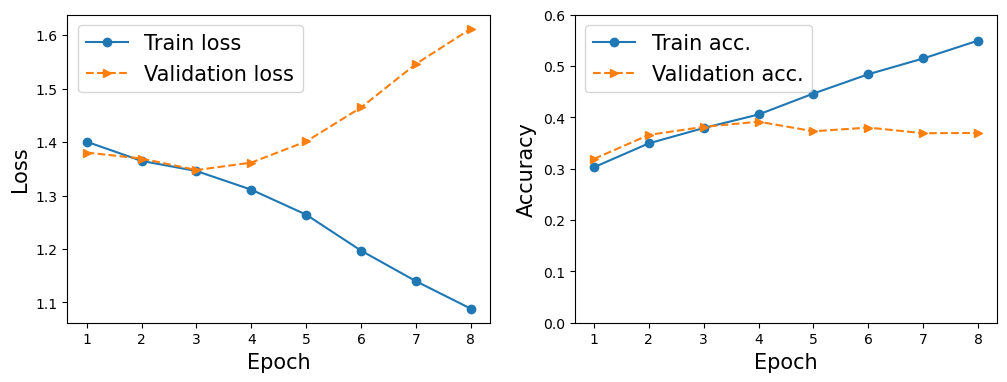

In [50]:
# Plot 
hist4 = history4.history
x_arr = np.arange(len(hist4['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist4['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist4['val_loss'], '-->', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist4['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist4['val_accuracy'], '-->', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,0.6)
plt.show()

In [51]:
# Classification report for ffnn4 on val set
y_val_pred_ffnn4 = np.argmax(ffnn4.predict([X_val_description, X_val_std]),axis=1)
print(classification_report(y_val, y_val_pred_ffnn4))

66/66 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.65      0.44       524
           1       0.35      0.04      0.07       523
           2       0.43      0.27      0.34       524
           3       0.43      0.56      0.49       523

    accuracy                           0.38      2094
   macro avg       0.39      0.38      0.33      2094
weighted avg       0.39      0.38      0.33      2094



In [52]:
# evaluate the model on test
ffnn4 = build_ffnn_with_embedding(num_features=X_train_std.shape[1], learning_rate=0.0025,
                                  vocab_size=vocab_size, embedding_dim=embedding_dim,
                                  maxlen=max_sequence_length)

test_loss4, test_accuracy4 = ffnn4.evaluate([X_test_description, X_test_std], y_test, verbose=1)
print('Test Loss: {}'.format(test_loss4))
print('Test Accuracy: {}'.format(test_accuracy4))

94/94 [==============================] - 1s 5ms/step - loss: 1.4449 - accuracy: 0.2720
Test Loss: 1.4448531866073608
Test Accuracy: 0.2720293700695038


In [53]:
# Classification report for ffnn4 on test set
y_test_pred_ffnn4 = np.argmax(ffnn4.predict([X_test_description, X_test_std]),axis=1)
print(classification_report(y_test, y_test_pred_ffnn4))

94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.33      0.06      0.10       719
           1       0.25      0.39      0.31       805
           2       0.10      0.00      0.01       641
           3       0.28      0.55      0.37       831

    accuracy                           0.27      2996
   macro avg       0.24      0.25      0.20      2996
weighted avg       0.25      0.27      0.21      2996



In [54]:
y_train.shape

(8374,)

## Transformers: TabNet

In [55]:
tb_cls = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                   optimizer_params=dict(lr=1e-3),
                   scheduler_params={"step_size":10, "gamma":0.9},
                   scheduler_fn=torch.optim.lr_scheduler.StepLR,
                   mask_type='entmax' # "sparsemax"
                   )

In [56]:
history_tab = tb_cls.fit(X_train_std,y_train,
               eval_set=[(X_train_std,y_train), (X_val_std, y_val)],
               eval_name=['train', 'valid'],
               eval_metric=['accuracy'],
               max_epochs=100 , patience=5,
               batch_size=16, drop_last=False) 

epoch 0  | loss: 1.65551 | train_accuracy: 0.25914 | valid_accuracy: 0.24928 |  0:00:08s
epoch 1  | loss: 1.44064 | train_accuracy: 0.26475 | valid_accuracy: 0.25597 |  0:00:18s
epoch 2  | loss: 1.40904 | train_accuracy: 0.27418 | valid_accuracy: 0.266   |  0:00:26s
epoch 3  | loss: 1.39625 | train_accuracy: 0.29102 | valid_accuracy: 0.27364 |  0:00:35s
epoch 4  | loss: 1.38679 | train_accuracy: 0.28935 | valid_accuracy: 0.27316 |  0:00:44s
epoch 5  | loss: 1.38345 | train_accuracy: 0.29914 | valid_accuracy: 0.28223 |  0:00:53s
epoch 6  | loss: 1.37962 | train_accuracy: 0.31323 | valid_accuracy: 0.29465 |  0:01:02s
epoch 7  | loss: 1.37594 | train_accuracy: 0.31419 | valid_accuracy: 0.29656 |  0:01:11s
epoch 8  | loss: 1.37132 | train_accuracy: 0.31526 | valid_accuracy: 0.30755 |  0:01:20s
epoch 9  | loss: 1.36851 | train_accuracy: 0.32398 | valid_accuracy: 0.31137 |  0:01:28s
epoch 10 | loss: 1.36876 | train_accuracy: 0.32911 | valid_accuracy: 0.31805 |  0:01:37s
epoch 11 | loss: 1.35

In [57]:
# Classification report for TabNet on test set
y_val_pred_tab = tb_cls.predict(X_val_std)
print(classification_report(y_val, y_val_pred_tab))

              precision    recall  f1-score   support

           0       0.33      0.59      0.43       524
           1       0.34      0.13      0.18       523
           2       0.42      0.23      0.30       524
           3       0.40      0.52      0.46       523

    accuracy                           0.37      2094
   macro avg       0.37      0.37      0.34      2094
weighted avg       0.37      0.37      0.34      2094



In [58]:
# Classification report for TabNet on test set
y_test_pred_tab = tb_cls.predict(X_test_std)
print(classification_report(y_test, y_test_pred_tab))

              precision    recall  f1-score   support

           0       0.32      0.59      0.42       719
           1       0.35      0.11      0.17       805
           2       0.34      0.21      0.26       641
           3       0.48      0.59      0.53       831

    accuracy                           0.38      2996
   macro avg       0.37      0.38      0.34      2996
weighted avg       0.38      0.38      0.35      2996



In [59]:
y_train.shape

(8374,)

### TabNet Cross validation 

In [60]:
# Standarising 
X_train_raw_std = scaler.fit_transform(X_train_raw.drop('Description',axis = 1))

# define and train the Tabnet model with cross validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
CV_score_array    =[]
for train_index, test_index in kf.split(X_train_raw_std):
    X_train, X_valid = X_train_raw_std[train_index], X_train_raw_std[test_index]
    y_train, y_valid = y_train_raw[train_index], y_train_raw[test_index]
    
    tb_cls_cv = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-3),
                       scheduler_params={"step_size":10, "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                       )
    
    tb_cls_cv.fit(X_train_raw_std,y_train_raw,
               eval_set=[(X_train_raw_std,y_train_raw), (X_valid, y_valid)],
               eval_name=['train', 'valid'],
               eval_metric=['accuracy'],
               max_epochs=100 , patience=5,
               batch_size=28, drop_last=False)  
    
    CV_score_array.append(tb_cls_cv.best_cost)

epoch 0  | loss: 1.67341 | train_accuracy: 0.25315 | valid_accuracy: 0.24499 |  0:00:07s
epoch 1  | loss: 1.43858 | train_accuracy: 0.2606  | valid_accuracy: 0.27125 |  0:00:14s
epoch 2  | loss: 1.40682 | train_accuracy: 0.26729 | valid_accuracy: 0.26504 |  0:00:21s
epoch 3  | loss: 1.39797 | train_accuracy: 0.28458 | valid_accuracy: 0.2851  |  0:00:28s
epoch 4  | loss: 1.38667 | train_accuracy: 0.29939 | valid_accuracy: 0.2937  |  0:00:36s
epoch 5  | loss: 1.38184 | train_accuracy: 0.30216 | valid_accuracy: 0.28988 |  0:00:43s
epoch 6  | loss: 1.3784  | train_accuracy: 0.31544 | valid_accuracy: 0.31089 |  0:00:50s
epoch 7  | loss: 1.37236 | train_accuracy: 0.3248  | valid_accuracy: 0.32092 |  0:00:57s
epoch 8  | loss: 1.36823 | train_accuracy: 0.32384 | valid_accuracy: 0.32139 |  0:01:04s
epoch 9  | loss: 1.36583 | train_accuracy: 0.32423 | valid_accuracy: 0.32474 |  0:01:12s
epoch 10 | loss: 1.35855 | train_accuracy: 0.33244 | valid_accuracy: 0.32617 |  0:01:19s
epoch 11 | loss: 1.36

In [61]:
# Classification report for TabNet cross validation on test set
y_test_pred_tab_cv = tb_cls_cv.predict(X_test_std)
print(classification_report(y_test, y_test_pred_tab_cv))

              precision    recall  f1-score   support

           0       0.34      0.56      0.42       719
           1       0.39      0.14      0.20       805
           2       0.31      0.25      0.27       641
           3       0.48      0.57      0.52       831

    accuracy                           0.38      2996
   macro avg       0.38      0.38      0.36      2996
weighted avg       0.38      0.38      0.36      2996



### TabNet explainability 

In [62]:
#explainer = shap.KernelExplainer(tb_cls.predict, shap.sample(X_train_std, 100))
#shap_values = explainer.shap_values(X_test_std,nsamples=100)

In [63]:
#features = X_train.columns.tolist()
#features

In [64]:
#shap.summary_plot(shap_values,X_test_std, feature_names=features) 

# Voting classifiers

## Among Neural Networks and Transformers

### Most often result

In [65]:
# Stack predictions 
stacked_results = np.vstack((y_test_pred_ffnn3, y_test_pred_tab))
stacked_results

array([[3, 0, 3, ..., 3, 0, 2],
       [3, 0, 0, ..., 0, 3, 0]])

In [66]:
y_test_voting_result_of = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_results)
print(y_test_voting_result_of)

[3 0 0 ... 0 0 0]


In [67]:
print(classification_report(y_test, y_test_voting_result_of))

              precision    recall  f1-score   support

           0       0.31      0.71      0.43       719
           1       0.30      0.07      0.12       805
           2       0.32      0.22      0.26       641
           3       0.54      0.44      0.48       831

    accuracy                           0.36      2996
   macro avg       0.37      0.36      0.32      2996
weighted avg       0.37      0.36      0.32      2996



### Average probability

In [68]:
y_test_pred_ffnn3_proba = ffnn3.predict(X_test_embed)
y_test_pred_tab_proba = tb_cls.predict_proba(X_test_std)
stacked_proba = (y_test_pred_ffnn3_proba + y_test_pred_tab_proba)/2
stacked_proba

94/94 [==============================] - 0s 2ms/step


array([[0.09489848, 0.15400949, 0.24336463, 0.5077274 ],
       [0.36954963, 0.2588215 , 0.20838213, 0.16324681],
       [0.24505031, 0.23742595, 0.23178384, 0.28573984],
       ...,
       [0.2975169 , 0.2472986 , 0.2174595 , 0.23772496],
       [0.23769686, 0.18907443, 0.16072816, 0.4125005 ],
       [0.29821616, 0.2853465 , 0.26712465, 0.14931269]], dtype=float32)

In [69]:
# Average result
y_test_voting_proba_avg_result = np.argmax(stacked_proba,axis=1)
y_test_voting_proba_avg_result

array([3, 0, 3, ..., 0, 3, 0])

In [70]:
print(classification_report(y_test, y_test_voting_proba_avg_result))

              precision    recall  f1-score   support

           0       0.34      0.54      0.42       719
           1       0.35      0.04      0.08       805
           2       0.33      0.26      0.29       641
           3       0.46      0.70      0.55       831

    accuracy                           0.39      2996
   macro avg       0.37      0.38      0.33      2996
weighted avg       0.37      0.39      0.34      2996



## Among all models

### Equal split embedding, Tabnet and XGboost

In [71]:
# Run best XGBoost model

#initialize classifier
xgb_model = xgb.XGBRegressor(
                              objective='multi:softprob', 
                              num_class = 4, 
                              booster='gbtree',
                              eval_metric = 'merror',
                              random_state=42,
                              max_depth = 5,
                              eta = .1,
                              n_estimators=10000,
                              early_stopping_rounds=100,
                              min_child_weight = 10,
                              gamma = 4,
                              colsample_bytree = .7,
                              reg_alpha = 1,
                              reg_lambda = 30,
                            )

#fit
xgb_fitted = xgb_model.fit(X_train_std, y_train,
                           eval_set=[(X_train_std, y_train), (X_val_std, y_val)],
                           verbose=20
                           )

XGBoostError: [15:23:00] /Users/runner/miniforge3/conda-bld/xgboost-split_1690927578751/work/src/data/data.cc:455: Check failed: this->labels.Size() % this->num_row_ == 0 (1 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017ced8cc0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017cf67f40 xgboost::MetaInfo::SetInfoFromHost(xgboost::GenericParameter const&, xgboost::StringView, xgboost::Json) + 676
  [bt] (2) 3   libxgboost.dylib                    0x000000017cf67af8 xgboost::MetaInfo::SetInfo(xgboost::GenericParameter const&, xgboost::StringView, xgboost::StringView) + 180
  [bt] (3) 4   libxgboost.dylib                    0x000000017ceee054 XGDMatrixSetInfoFromInterface + 240
  [bt] (4) 5   libffi.8.dylib                      0x0000000100ee404c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x0000000100ee174c ffi_call_int + 1208
  [bt] (6) 7   _ctypes.cpython-39-darwin.so        0x0000000100ec4544 _ctypes_callproc + 1324
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x0000000100ebe850 PyCFuncPtr_call + 1176
  [bt] (8) 9   python3.9                           0x00000001005613c4 _PyObject_MakeTpCall + 616



In [ ]:
# Make prediction with fitted XGboost
y_test_pred_rf = xgb_fitted.predict(X_test_std)

# Average predictions
stacked_proba_2 = (y_test_pred_ffnn3_proba + y_test_pred_tab_proba + y_test_pred_rf) / 3
stacked_proba_2

In [ ]:
# Average result
y_test_voting_proba_avg_result2 = np.argmax(stacked_proba_2,axis=1)
print(classification_report(y_test, y_test_voting_proba_avg_result2))

### 50% weight XGboost, 25% embedding, 25% TabNet

In [ ]:
# Weighted Average predictions
stacked_proba_3 = (0.25*y_test_pred_ffnn3_proba) + (0.25*y_test_pred_tab_proba) + (0.50*y_test_pred_rf)
print(classification_report(y_test, np.argmax(stacked_proba_3,axis=1)))